In [ ]:
'''
Исходные данные: текст из файла размером не менее 20-ти страниц
Цель:            дать на выход таблицу, где по каждому уникальному слову из исходного текста дается значение частоты появления
                 данного слова. При этом уникальным слово не считается, если в тексте уже есть "похожее" на это другое слово.
Ограничения:     два слова счичтаются "похожими", если они являются однокоренными, или у них отличаются только окончания/
                 приставки/суфиксы и т.п., где допускается небольшая погрешность в связи со сложной структурой естественного
                 языка (в особенности, русского). 
                 вычисления производить только с помощью numpy и pandas.
Гипотеза:        один из алгоритмов нахождения расстояния между двумя строками должен решить поставленную задачу.
Реализация:      было опробовано построение векторов из каждого слова размерностью в количество букв в кириллице и проверены 
                 расстояния Минковского, Манхэттонское, косинусное и евклидово. За счет того, что подобные векторы не учитывают
                 положения букв в слове, очевидно, распределение получилось весьма неточным. Сравнение двух слов алгоритмами 
                 Левенштейна, Дамерау - Левенштейна, Джаро — Винклера и Хэмминга оказались намного эффективнее. Лучше всего 
                 показала себя реализация расстояния Джаро — Винклера, при настройке которого (определение оптимального 
                 коэффициэнта масштабирования и порога расстояния, на котором слова считаются похожими) погрешность группировки 
                 похожих слов стремится к минимуму.

In [3]:
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
%matplotlib inline

In [4]:
#функция нахождения расстояние "Джаро — Винклера": https://en.wikipedia.org/wiki/Jaro%E2%80%93Winkler_distance
def jaro_winkler(first, second, scaling=0.1):
    if not first or not second:
        raise JaroDistanceException("Cannot calculate distance from NoneType ({0}, {1})".format(
            first,
            second))

    jaro = score(first, second)
    cl = min(len(get_prefix(first, second)), 4)
    return ((jaro + (scaling * cl * (1.0 - jaro))) * 100.0) / 100.0

    return jaro


def score(first, second): #функция нахождения расстояние Джаро
    shorter, longer = first.lower(), second.lower()

    if len(first) > len(second):
        longer, shorter = shorter, longer

    m1 = get_matching_characters(shorter, longer)
    m2 = get_matching_characters(longer, shorter)

    if len(m1) == 0 or len(m2) == 0:
        return 0.0

    return (float(len(m1)) / len(shorter) +
            float(len(m2)) / len(longer) +
            float(len(m1) - transpositions(m1, m2)) / len(m1)) / 3.0


def get_diff_index(first, second): #находим количество первых совпадающих букв слов
    if first == second:
        return -1

    if not first or not second:
        return 0

    limit = min(len(first), len(second))
    for i in range(limit):
        if not first[i] == second[i]:
            return i


def get_prefix(first, second): #находим общий префикс слов от начала до максимума
    if not first or not second:
        return ''

    index = get_diff_index(first, second)
    if index == -1:
        return first
    elif index == 0:
        return ''
    else:
        return first[0:index]


def get_matching_characters(first, second): #находим одинкаовые буквы в пределах limit (тут высчитывается не по оригинальной
    common = []                             #формуле дистанции Джаро — Винклера)
    limit = int(np.floor(min(len(first), len(second)) / 2))

    for i, l in enumerate(first):
        left, right = int(max(0, i - limit)), int(min(i + limit + 1, len(second)))
        if l in second[left:right]:
            common.append(l)
            second = second[0:second.index(l)] + '*' + second[second.index(l) + 1:]

    return ''.join(common)


def transpositions(first, second): #находим значение транспозиции
    return int(np.floor(len([(f, s) for f, s in zip(first, second) if not f == s]) / 2.0))

In [5]:
#загрузка текста, очистка и разбиение на слова
with open(r'Data\Amonenko_Dissertatsia.txt', 'r') as file:
    txt = file.read().lower()
words = txt.split(' ')
junk_chars = '!@#$%^&*()_+=0987654321?|,.`~qwertyuionp][}{asdfghjkl;:zcvbmQWERTYUIOPASD""FGHJKLZXCVBNM“”—«»–…\t'
words = txt.translate({ord(c): None for c in junk_chars})
words = words.translate({ord(c): ' ' for c in '\n\xa0/'}).split(' ')
words = list(filter(None, words)) #список всех слов текста
uniq_words = list(set(words)) #список уникальных слов текста
print('Количество слов: %s' % len(words))
print('Количество уникальных слов: %s' % len(uniq_words))

Количество слов: 17518
Количество уникальных слов: 5163


In [6]:
#датафрейм из уникальных слов
sr = pd.Series(data=Counter(words))
df = pd.DataFrame(data=sr)

In [7]:
#Расчет расстояния Джаро — Винклера для каждой пары уникальных слов
for i, l in tqdm(enumerate(df.index)):
    df[l] = [jaro_winkler(l, k, scaling=0.16) if j>=i else df.loc[l, df.columns[j+1]] for j, k in enumerate(df.index)]

In [8]:
#формируем словарь {слово: похожие слова}, где похожие - это слова с дистанцией более значения distance
#методом проб была выбрана дистанция 0.965
distance = 0.965
sim_words = {i: '' for i in df.index}
sim_words = {j: [i for i in df.loc[(df[j] >= distance) & (df[j] != 1)].index] for j in tqdm(sim_words)}

In [9]:
#объединение похожих слов в единые списки-"облака"
clouds = []
for i in sim_words:
    if sim_words[i] == []:
        clouds.append([i])
        sim_words[i] = ['*']
    elif sim_words[i] == ['*']:
        continue
    else:
        clouds.append([i])
        for j in clouds[-1]:
            if sim_words[j] != ['*']:
                clouds[-1] += sim_words[j]
                sim_words[j] = ['*']
        clouds[-1] = list(set(clouds[-1]))

In [10]:
#считаем количество упоминаний слов, размер, среднюю длину слова и TF для каждого "облака"
count = [0 for i in range(len(clouds))]
TF = [0 for i in range(len(clouds))]
cl_len = [0 for i in range(len(clouds))]
for i in tqdm(clouds):
    for j in i:
        count[clouds.index(i)] += df.loc[j, 0]
    TF[clouds.index(i)] = count[clouds.index(i)] / len(words)
    cl_len[clouds.index(i)] = len(i)
cloud_count = pd.DataFrame(data={'Cloud' : clouds, 'Len' : cl_len, 'Count' : count, 'TF': TF})

In [11]:
#добавляем столбик со средней длиной слова в "облаке"
cloud_count['Mean_Word_Len'] = [round(sum([len(j) for j in i])/len(i)) for i in cloud_count.Cloud]

In [17]:
#самые часто встречаемые слова (больше 3-х букв, так как они интереснее)
pd.options.display.max_rows = 230
cloud_count.sort_values(['TF'], ascending=False)[cloud_count['Mean_Word_Len'] >= 4]

C:\Users\rad0_\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


,Cloud,Len,Count,TF,Mean_Word_Len
355,"[идеологическая, идеологии, идеологическими, и...",17,204,0.011645,13
14,"[философский, философа, философии, философской...",21,163,0.009305,10
139,"[структурных, структуру, структурного, структу...",15,159,0.009076,10
242,"[которых, которым, которому, который, котором,...",8,147,0.008391,7
179,"[альюссера, альтюссеру, альтюссер, альтюссерем...",7,142,0.008106,10
598,"[практическую, практиками, практике, практичес...",17,111,0.006336,10
82,"[марксистские, марксистскую, марксистский, мар...",12,110,0.006279,12
4,"[марксу, маркса, маркс, марксом, марксе]",5,109,0.006222,6
97,"[теоретический, теоретического, теоретическая,...",13,105,0.005994,13
339,"[являются, является, являют, являет]",4,104,0.005937,7


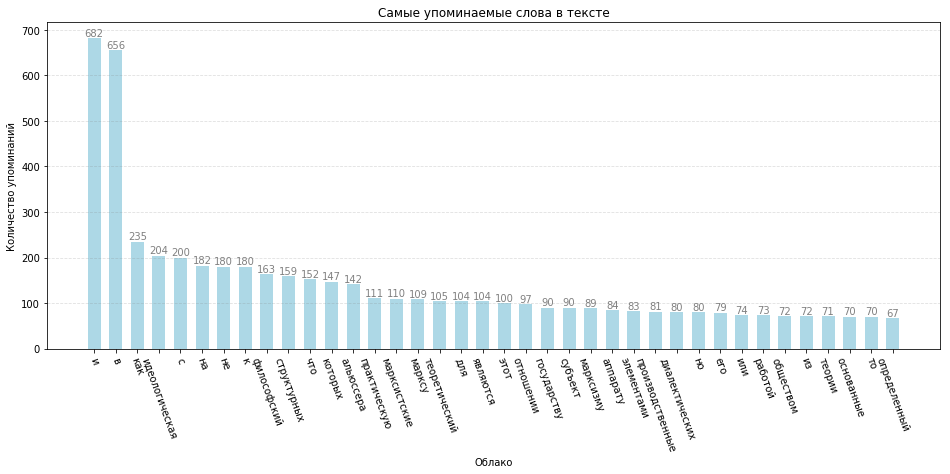

In [14]:
fig = plt.figure(figsize=(16, 6)) #создаем фигуру
ax = fig.add_subplot(111) #создаем область
ax.set_title(u'Самые упоминаемые слова в тексте')
ax.set_xlabel(u'Облако')
ax.set_ylabel(u'Количество упоминаний')

n = 38 #количество выводимых слов
x = np.arange(n)
y = [i for i in cloud_count.sort_values(['TF'], ascending=False)['Count'][:n]]

ax.grid(True, axis='y', which='major', color='grey', linestyle='dashed', alpha=0.25)
ax.set_xticks(x) #интервал делений по оси x
xlabels = [str(i[0]) for i in cloud_count.sort_values(['TF'], ascending=False)['Cloud'][:n]]
ax.set_xticklabels(xlabels, rotation=290)
ax1 = plt.bar(x, y, 0.6, color='#ADD8E6')
for bar in ax1: #подписи над столбиками
    ax.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
            '%d' % int(bar.get_height()), ha='center', va='bottom',
            fontsize=10, color='grey')

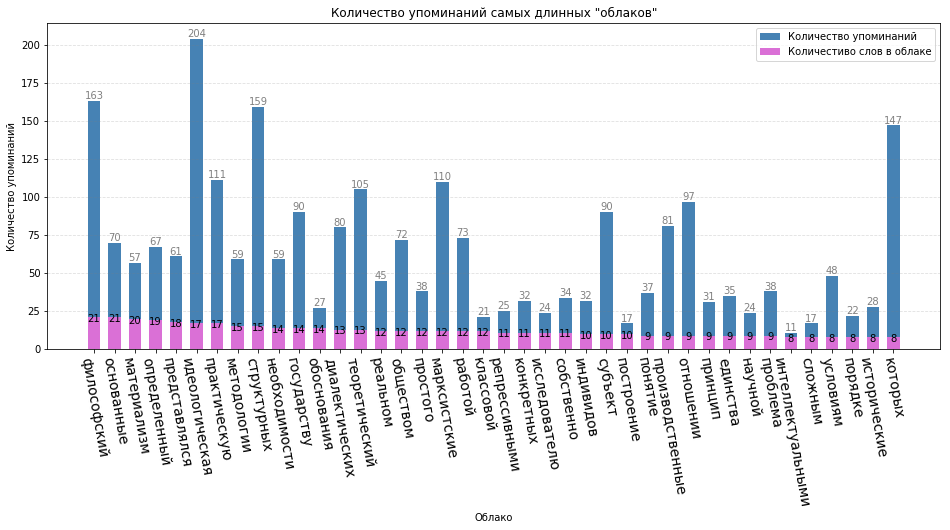

In [15]:
fig = plt.figure(figsize=(16, 6)) #создаем фигуру
ax = fig.add_subplot(111) #создаем область
ax.set_title(u'Количество упоминаний самых длинных "облаков"')
ax.set_xlabel(u'Облако')
ax.set_ylabel(u'Количество упоминаний')

n = 40 #количество выводимых облаков
x = np.arange(n)
y = [i for i in cloud_count.sort_values(['Len'], ascending=False)['Count'][:n]]
y1 = [i for i in cloud_count.sort_values(['Len'], ascending=False)['Len'][:n]]

ax.grid(True, axis='y', which='major', color='grey', linestyle='dashed', alpha=0.25)
ax.set_xticks(x) #интервал делений по оси x
xlabels = [str(i[0]) for i in cloud_count.sort_values(['Len'], ascending=False)['Cloud'][:n]]
ax.set_xticklabels(xlabels, rotation=280, fontsize=14)
ax1 = plt.bar(x, y, 0.6, color='#4682B4', label=u'Количество упоминаний')
ax2 = plt.bar(x, y1, 0.6, color='#DA70D6', label=u'Количестиво слов в облаке')
for bar in ax1: #подписи над столбиками
    ax.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
            '%d' % int(bar.get_height()), ha='center', va='bottom',
            fontsize=10, color='grey')
for bar in ax2: #подписи над столбиками
    ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() - 4.3,
            '%d' % int(bar.get_height()), ha='center', va='bottom',
            fontsize=10, color='black')
ax.legend(loc='best')

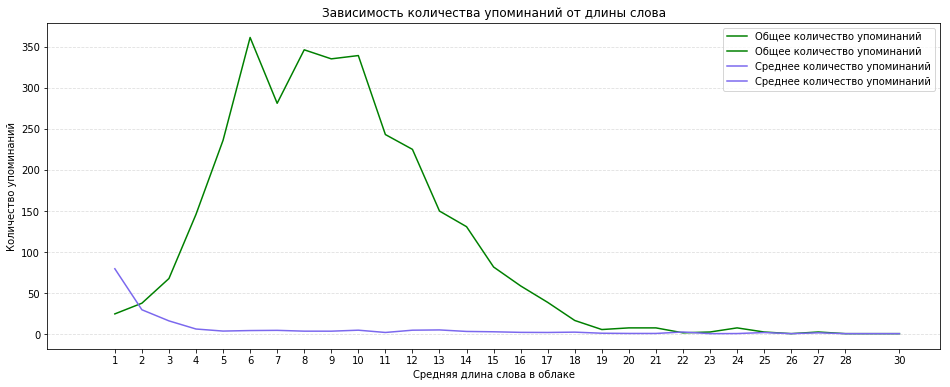

In [16]:
fig = plt.figure(figsize=(16, 6)) #создаем фигуру
ax = fig.add_subplot(111) #создаем область
ax.set_title(u'Зависимость количества упоминаний от длины слова')
ax.set_xlabel(u'Средняя длина слова в облаке')
ax.set_ylabel(u'Количество упоминаний')

g = cloud_count.groupby(['Mean_Word_Len'])

x = g.agg(np.size).index
y = g.agg(np.size)['Count']
y1 = g.agg(np.mean)['Count']

ax.grid(True, axis='y', which='major', color='grey', linestyle='dashed', alpha=0.25)
ax.set_xticks(x) #интервал делений по оси x
xlabels = x
ax.set_xticklabels(xlabels, fontsize=10)
ax1 = plt.plot(x, y, 0.6, color='#008000', label=u'Общее количество упоминаний')
ax2 = plt.plot(x, y1, 0.6, color='#7B68EE', label=u'Среднее количество упоминаний')
ax.legend(loc='best')

In [20]:
#Требуемый DataFrame
final = pd.DataFrame(data=[cloud_count.Cloud, cloud_count.TF])
final

,0,1,2,3,4,5,6,7,8,9,...,3155,3156,3157,3158,3159,3160,3161,3162,3163,3164
Cloud,[введение],[философско-теоретическое],"[наследие, наследия, наследии]",[к],"[марксу, маркса, маркс, марксом, марксе]","[вызвал, вызвало]",[огромный],[интерес],[и],"[были, был, было, была]",...,[дальнейшую],[джону],[льюису],"[самокритики, самокритика]",[учеников],[балибара],[бадью],[концентрация],[сужение],[ориентиром]
TF,0.000171252,5.70841e-05,0.000513757,0.0102751,0.00622217,0.000114168,5.70841e-05,0.000285421,0.0389314,0.00188378,...,5.70841e-05,5.70841e-05,5.70841e-05,0.000114168,5.70841e-05,5.70841e-05,5.70841e-05,5.70841e-05,5.70841e-05,5.70841e-05
